##Heating Data Profile Extraction for HPZ Building

This notebook will extract typical profiles from the HPZ Heating meter for use as input for the coupled co-simulation with CitySim

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline 

In [13]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [14]:
# os.chdir(workingdir)

In [15]:
df_QW = pd.read_csv(workingdir+"/aggset2_QW/HPZ_QW.csv", index_col="Date Time", parse_dates=True)

In [16]:
df_QW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70201 entries, 2006-01-07 00:00:00 to 2014-01-10 00:00:00
Data columns (total 11 columns):
HPZMEL01QW_A [kWh]    54340 non-null float64
HPZMEL50QW_A [kWh]    18320 non-null float64
HPZMEL51QW_A [kWh]    11936 non-null float64
HPZMEL52QW_A [kWh]    18320 non-null float64
HPZMEL53QW_A [kWh]    6106 non-null float64
HPZMEL98QW_A [kWh]    54340 non-null float64
HPZMEL99QW_A [kWh]    54340 non-null float64
HPZMHE01QW_A [kWh]    67059 non-null float64
HPZMHE96QW_A [kWh]    10464 non-null float64
HPZMKA01QW_A [kWh]    70169 non-null float64
HPZMKA96QW_A [kWh]    10464 non-null float64
dtypes: float64(11)
memory usage: 6.4 MB


In [23]:
point = "HPZMHE01QW_A [kWh]"

In [24]:
df_heat = pd.DataFrame(df_QW[point].truncate(before='2013',after='2014'))

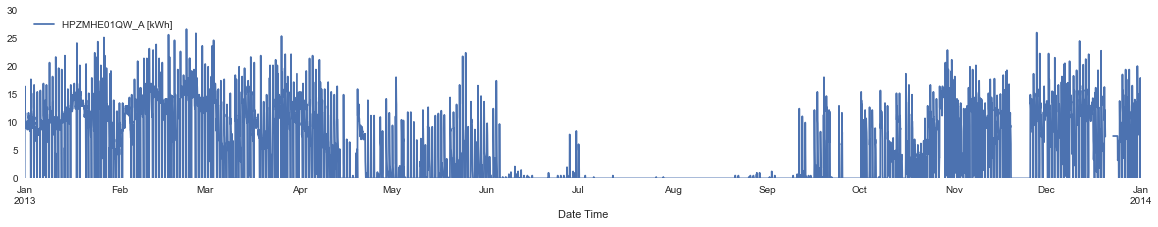

In [25]:
df_heat.plot(figsize=(20,3));

In [26]:
df_heat_QW = pd.DataFrame(df_QW["HPZMHE01QW_A [kWh]"].truncate(before='2013',after='2014'))

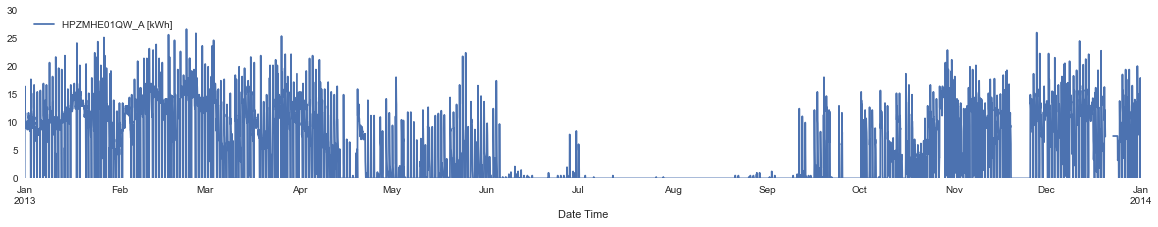

In [27]:
df_heat_QW.plot(figsize=(20,3));

##Convert to SAX

In [33]:
df = df_heat_QW.dropna()

In [34]:
#df.head()

In [35]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [40]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [41]:
a = 3
w = '4h'

In [42]:
from scipy.stats import norm
import numpy as np
import string

In [43]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [44]:
df_forSAX = df["HPZMHE01QW_A [kWh]"]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

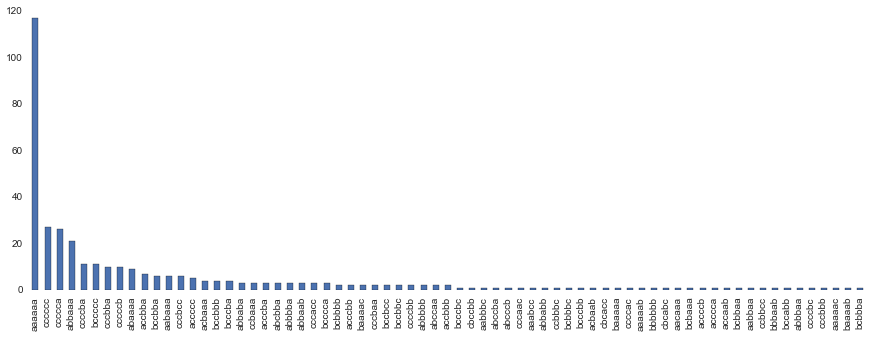

In [45]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [46]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

aaaaaa    117
cccccc     27
ccccca     26
abbaaa     21
ccccba     11
bccccc     11
cccbba     10
cccccb     10
abaaaa      9
dtype: int64

In [47]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

accbba    7
bccbba    6
aabaaa    6
cccbcc    6
accccc    5
dtype: int64

In [48]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [49]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [50]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [51]:
# df = motifdata.drop(['SAXstring'], axis=1)

In [52]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,16.50,11.00,12.25,11.25,11.75,10.25,10.25,10.25,10.25,...,9.25,9.00,9.00,9.25,9.50,9.25,9.25,8.75,9.25,10.00
2013-01-02,10.25,9.50,10.00,9.50,10.50,11.25,11.75,10.75,11.25,11.00,...,9.50,8.75,8.50,10.25,10.00,10.00,10.75,11.25,11.25,2.75
2013-01-03,0.00,17.75,12.00,12.50,12.75,15.25,12.00,12.00,11.75,11.50,...,9.75,9.00,9.75,9.50,9.25,9.75,10.25,9.75,9.75,2.25
2013-01-04,0.00,0.50,16.75,11.25,10.50,11.00,9.75,10.00,9.00,9.25,...,7.00,6.75,7.00,6.75,7.00,7.00,8.25,7.50,8.00,2.00
2013-01-05,0.00,0.00,0.00,15.50,8.75,8.50,8.50,8.00,8.25,8.75,...,7.75,8.75,8.25,8.50,8.75,8.75,8.50,8.75,8.50,9.00


In [53]:
df = df_pivot

In [54]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [55]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = ["HPZ_Heating"]
df = df.resample('H')

In [56]:
df.head()

,HPZ_Heating
timestampstring,
2013-01-01 00:00:00,0.00
2013-01-01 01:00:00,16.50
2013-01-01 02:00:00,11.00
2013-01-01 03:00:00,12.25
2013-01-01 04:00:00,11.25


In [57]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [58]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [59]:
dailyblocks = pd.pivot_table(df, values='HPZ_Heating', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values='HPZ_Heating', index='Date', columns='Time', aggfunc='mean')

In [60]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [61]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [62]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [63]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [64]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

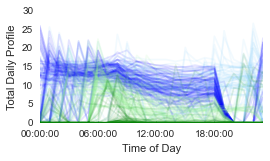

In [65]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("heating_clusters_total_overlaid_profiles.pdf")

In [66]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [67]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

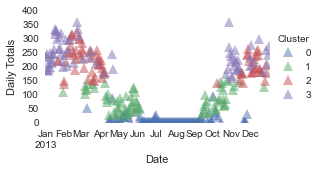

In [68]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("heating_clusters_overtime.pdf")

In [69]:
dailyclusters.head()

ClusterNo2          3                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
00:00:00         0.00      10.25       0.00       0.00       0.00       2.50   
01:00:00        16.50       9.50      17.75       0.50       0.00       0.00   
02:00:00        11.00      10.00      12.00      16.75       0.00       0.00   
03:00:00        12.25       9.50      12.50      11.25      15.50      15.75   
04:00:00        11.25      10.50      12.75      10.50       8.75      10.00   

ClusterNo2                                                ...              0  \
Date       2013-01-07 2013-01-08 2013-01-09 2013-01-10    ...     2013-10-04   
00:00:00         2.75       0.00       0.00       0.00    ...              0   
01:00:00         0.00       0.00       1.00       0.00    ...              0   
02:00:00         4.00       0.00       7.00       6.75    ...              0   
03:00:00        17.00      16.75      20.75      18.25    ...              0   
04:00:00        11.25      10.00      12.25      11.00    ...              0   

ClusterNo2                                                                    \
Date       2013-10-07 2013-10-09 2013-10-15 2013-11-20 2013-11-21 2013-11-22   
00:00:00            0          0          0          0          0          0   
01:00:00            0          0          0          0          0          0   
02:00:00            0          0          0          0          0          0   
03:00:00            0          0          0          0          0          0   
04:00:00            0          0          0          0          0          0   

ClusterNo2                                   
Date       2013-11-23 2013-11-24 2013-11-25  
00:00:00            0          0          0  
01:00:00            0          0          0  
02:00:00            0          0          0  
03:00:00            0          0          0  
04:00:00            0          0          0  

[5 rows x 361 columns]

In [70]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,NaN,NaN,NaN,232.75
2013-01-02,NaN,NaN,NaN,237.25
2013-01-03,NaN,NaN,NaN,246.75
2013-01-04,NaN,NaN,NaN,186.50
2013-01-05,NaN,NaN,NaN,185.25


In [71]:
calendar.to_csv("heating_calendar.csv")

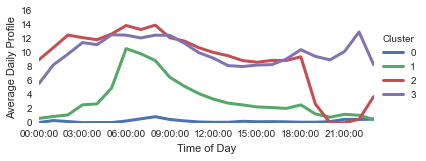

In [72]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("heating_clusters_averagedprofiles.pdf")

In [73]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

26.75

In [74]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / (dfclusterunstackedpivoted.groupby('Time').max().max().max()*0.7)

In [75]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.head()

ClusterNo2,0,1,2,3
Time,,,,
00:00:00,0.001799,0.033897,0.481783,0.299042
01:00:00,0.017233,0.048421,0.575943,0.443807
02:00:00,0.009706,0.060419,0.671949,0.525821
03:00:00,0.001231,0.137549,0.652095,0.614415
04:00:00,0.002320,0.144946,0.636061,0.598203


In [76]:
normalizedprofiles.to_csv("heating_schedules.csv")

In [77]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

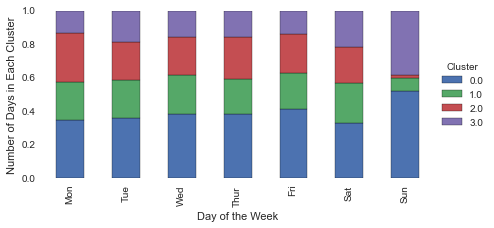

In [78]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("heating_clusters_dailybreakdown.png")

In [79]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.346154,0.230769,0.288462,0.134615
Tue,0.358491,0.226415,0.226415,0.188679
Wed,0.384615,0.230769,0.230769,0.153846
Thur,0.384615,0.211538,0.250000,0.153846
Fri,0.411765,0.215686,0.235294,0.137255
Sat,0.333333,0.235294,0.215686,0.215686
Sun,0.520000,0.080000,0.020000,0.380000


##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [80]:
normalizedprofiles = pd.read_csv("heating_schedules.csv", index_col='Time')

In [81]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.001799,0.033897,0.481783,0.299042
01:00:00,0.017233,0.048421,0.575943,0.443807
02:00:00,0.009706,0.060419,0.671949,0.525821
03:00:00,0.001231,0.137549,0.652095,0.614415
04:00:00,0.002320,0.144946,0.636061,0.598203


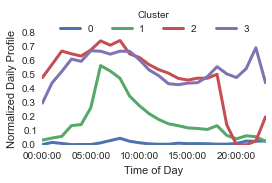

In [82]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("heating_clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [83]:
calendar = pd.read_csv("heating_calendar.csv", index_col='timestampstring', parse_dates=True)

In [84]:
#calendar.fillna(0).dropna(how="all").info()

In [85]:
import time

In [86]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [87]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356994800,NaN,NaN,NaN,232.75,1356994800
1357081200,NaN,NaN,NaN,237.25,1357081200
1357167600,NaN,NaN,NaN,246.75,1357167600
1357254000,NaN,NaN,NaN,186.50,1357254000
1357340400,NaN,NaN,NaN,185.25,1357340400


In [88]:
calendar = calendar.drop(['epochtime'], axis=1)

In [89]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356994800,NaN,NaN,NaN,232.75
1357081200,NaN,NaN,NaN,237.25
1357167600,NaN,NaN,NaN,246.75
1357254000,NaN,NaN,NaN,186.50
1357340400,NaN,NaN,NaN,185.25


In [90]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [91]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1362870000,50.75
1,0,1365890400,8.25
2,0,1366063200,9.25
3,0,1366149600,10.50
4,0,1366236000,0.75


In [92]:
cal_heatmap.index = cal_heatmap.epochtime

In [93]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1362870000,0,1362870000,50.75
1365890400,0,1365890400,8.25
1366063200,0,1366063200,9.25
1366149600,0,1366149600,10.50
1366236000,0,1366236000,0.75


In [94]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [95]:
cal_heatmap = cal_heatmap.sort()

In [96]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [97]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    361 non-null float64
dtypes: float64(1)
memory usage: 5.6 KB


In [98]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,3
1357081200,3
1357167600,3
1357254000,3
1357340400,3


In [99]:
cal_heatmap = cal_heatmap+1

In [100]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,4
1357081200,4
1357167600,4
1357254000,4
1357340400,4


In [101]:
cal_heatmap.level_0.to_json("heating_hpz_cal_heatmap.json")

In [19]:
x = sns.color_palette()

In [22]:
import matplotlib.colors as colors

In [26]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
